# **Task II: Classical Graph Neural Network (GNN)**

For Task II, you will use ParticleNet’s data for Quark/Gluon jet classification available here with its corresponding description.

● Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges.

● Discuss the resulting performance of the 2 chosen architectures.


# Description of the dataset

**The dataset contains:**

X: (100000, M, 4), where M is the max number of particles in a jet.(139)

(50k Quark, 50k Gluon)

**Each particle has four features:**

Transverse momentum (
𝑝
𝑇
​
 )

Rapidity (
𝜂
)

Azimuthal angle (
𝜙
)

PDG ID

Dataset Overview:
  - Total Jets: 100000 (50k Quark, 50k Gluon, randomly sorted)
  - Max Particles Per Jet: 139
  - Features per Particle: 4 (pT, Rapidity, Azimuth, PDG ID)
  - Labels: (100000,) (0 = Gluon, 1 = Quark)



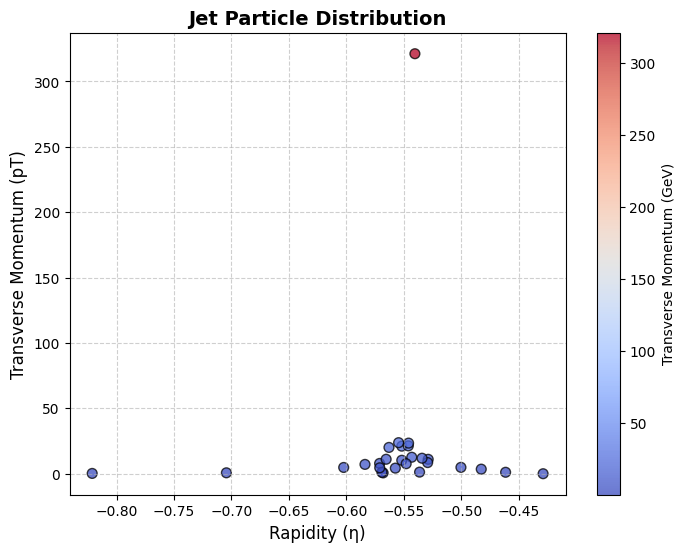

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = "/content/QG_jets.npz"
data = np.load(file_path)

# Extract arrays
X = data["X"]  # Shape: (100000, M, 4) → Particle features per jet
y = data["y"]  # Shape: (100000,) → Jet labels (0: Gluon, 1: Quark)

# Dataset Description
print("Dataset Overview:")
print(f"  - Total Jets: {X.shape[0]} (50k Quark, 50k Gluon, randomly sorted)")
print(f"  - Max Particles Per Jet: {X.shape[1]}")
print(f"  - Features per Particle: {X.shape[2]} (pT, Rapidity, Azimuth, PDG ID)")
print(f"  - Labels: {y.shape} (0 = Gluon, 1 = Quark)\n")

# Select a sample jet
jet_index = 10  # Choosing the 10th jet as an example
jet_particles = X[jet_index]

# Extract transverse momentum (pT) and rapidity (η)
pt = jet_particles[:, 0]  # Column 0: Transverse momentum (pT)
eta = jet_particles[:, 1]  # Column 1: Rapidity (η)

# Filter out zero-padded particles
nonzero_mask = pt > 0
pt = pt[nonzero_mask]
eta = eta[nonzero_mask]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(eta, pt,c=pt, cmap="coolwarm", alpha=0.75, edgecolors="black", s=50)
plt.colorbar(label="Transverse Momentum (GeV)")
plt.xlabel("Rapidity (η)", fontsize=12)
plt.ylabel("Transverse Momentum (pT)", fontsize=12)
plt.title("Jet Particle Distribution", fontsize=14, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.show()

# Inference from the Jet Particle Distribution Graph

The scatter plot visualizes the distribution of jet particles in terms of rapidity (η) and transverse momentum (pT). **Most particles are clustered near η ≈ -0.55** with relatively low transverse momentum (pT < 50 GeV), suggesting a **dense core of lower-energy particles**. A **single outlier** with significantly high pT (> 300 GeV) is observed, which may correspond to a **leading particle carrying a substantial fraction of the jet’s energy**. The color gradient further reinforces the momentum distribution, highlighting how energy is dispersed among the particles.



---



---



# Why we use a Graph Neural Network (GNN) for Jet Classification?

Jets being collections of particles resulting from high-energy interactions, exhibit complex spatial and energy correlations, making them well-suited for graph-based representations rather than traditional grid-based methods like CNNs

***A Graph Neural Network (GNN) is particularly useful because:***


*   **Particle Interactions**: Jets can be naturally modeled as point clouds, where each particle is a node and edges represent possible interactions (e.g., energy flow, spatial proximity).
*   **Permutation Invariance**: Unlike traditional methods, GNNs inherently respect the unordered nature of particle sets, making them order-invariant while preserving relational structure.
*   **Feature Propagation**: GNNs capture both local and global dependencies in jet substructures, helping distinguish quark jets (which are more collimated) from gluon jets (which are more diffuse).
*   **Scalability**: Since jet data varies in size (i.e., different numbers of particles per jet), GNNs adapt dynamically, unlike dense neural networks that require fixed input dimensions.


---

---





# 1st Graph-based architecture: Graph Attention Networks (GAT)
We use a Graph Attention Network (GAT) to classify quark and gluon jets by representing each jet as a graph where particles (with features like pT, rapidity, azimuth, and PDG ID) are nodes. The GATConv layers dynamically weight neighboring particles through multi-head attention, effectively capturing the local substructure within each jet. Global mean pooling then aggregates these weighted features into a robust jet-level representation for final classification.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

!pip install torch-scatter -f https://data.pyg.org/whl/torch-$(python -c 'import torch; print(torch.__version__)').html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-$(python -c 'import torch; print(torch.__version__)').html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-$(python -c 'import torch; print(torch.__version__)').html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-$(python -c 'import torch; print(torch.__version__)').html
!pip install torch-geometric


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from torch_cluster import knn_graph
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

# Data Preprocessing Function
def load_and_preprocess(file_path, num_particles=100, k=8):  # Using k=8 for speed
    data = np.load(file_path)
    features = data['X']
    labels = data['y']

    processed_data = []
    for i in range(features.shape[0]):
        jet_features = features[i]

        # Pad or truncate to a fixed number of particles
        if jet_features.shape[0] > num_particles:
            jet_features = jet_features[:num_particles]
        else:
            padding = np.zeros((num_particles - jet_features.shape[0], 4))
            jet_features = np.concatenate([jet_features, padding], axis=0)

        # Normalize features (standardization)
        jet_features = (jet_features - np.mean(jet_features, axis=0)) / (np.std(jet_features, axis=0) + 1e-6)

        x = torch.tensor(jet_features, dtype=torch.float)
        y = torch.tensor(labels[i], dtype=torch.long)

        # Construct k-NN graph (using (η, φ) columns 1 and 2)
        edge_index = knn_graph(x[:, 1:3], k=k, batch=None)

        # Create a PyG Data object
        processed_data.append(Data(x=x, edge_index=edge_index, y=y))

    return processed_data

# Define the GAT Model
class GATNet(nn.Module):
    def __init__(self, num_features=4, num_classes=2, hidden_dim=32, heads=2):
        super(GATNet, self).__init__()
        self.conv1 = GATConv(num_features, hidden_dim, heads=heads, dropout=0.3, concat=True)
        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=heads, dropout=0.3, concat=True)
        self.lin1 = nn.Linear(hidden_dim * heads, 64)
        self.lin2 = nn.Linear(64, num_classes)

    def forward(self, data):
        # Assume data is a Batch object with a valid 'batch' attribute
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return F.log_softmax(x, dim=1)

# Training Function
def train(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Evaluation Function
def evaluate(model, loader, device):
    model.eval()
    correct, all_preds, all_labels = 0, [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            all_preds.extend(torch.exp(out)[:, 1].cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())
    acc = correct / len(loader.dataset)
    auc = roc_auc_score(all_labels, all_preds)
    return acc, auc

# Main Execution
if __name__ == '__main__':
    file_path = '/content/QG_jets.npz'
    num_particles, k, batch_size, epochs, lr = 100, 8, 16, 20, 0.001
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
     # Load and preprocess data (this loads the entire dataset)
    processed_data = load_and_preprocess(file_path, num_particles=num_particles, k=k)

    # Use only a subset (e.g., first 10,000 jets) for faster testing
    processed_data = processed_data[:10000]

    # Load and preprocess data
    processed_data = load_and_preprocess(file_path, num_particles=num_particles, k=k)
    train_data, test_data = train_test_split(processed_data, test_size=0.2, random_state=42)

    # DataLoader automatically collates Data objects into a Batch with 'batch' attribute
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

    # Initialize model and optimizer using the correct parameter names
    model = GATNet(num_features=4, hidden_dim=32, num_classes=2, heads=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training Loop
    print("Training GAT Model...")
    for epoch in range(1, epochs + 1):
        loss = train(model, train_loader, optimizer, device)
        train_acc, train_auc = evaluate(model, train_loader, device)
        test_acc, test_auc = evaluate(model, test_loader, device)
        print(f'Epoch {epoch:02d}: Loss={loss:.4f}, Train Acc={train_acc:.4f}, Train AUC={train_auc:.4f}, Test Acc={test_acc:.4f}, Test AUC={test_auc:.4f}')

    print("Training Complete!")



Training GAT Model...


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 01: Loss=0.4969, Train Acc=0.7780, Train AUC=0.8498, Test Acc=0.7832, Test AUC=0.8539
Epoch 02: Loss=0.4812, Train Acc=0.7807, Train AUC=0.8548, Test Acc=0.7871, Test AUC=0.8585
Epoch 03: Loss=0.4776, Train Acc=0.7852, Train AUC=0.8569, Test Acc=0.7901, Test AUC=0.8611
Epoch 04: Loss=0.4745, Train Acc=0.7878, Train AUC=0.8599, Test Acc=0.7895, Test AUC=0.8631
Epoch 05: Loss=0.4719, Train Acc=0.7848, Train AUC=0.8598, Test Acc=0.7869, Test AUC=0.8629
Epoch 06: Loss=0.4707, Train Acc=0.7836, Train AUC=0.8601, Test Acc=0.7871, Test AUC=0.8631
Epoch 07: Loss=0.4690, Train Acc=0.7831, Train AUC=0.8623, Test Acc=0.7849, Test AUC=0.8649
Epoch 08: Loss=0.4687, Train Acc=0.7876, Train AUC=0.8622, Test Acc=0.7911, Test AUC=0.8651
Epoch 09: Loss=0.4677, Train Acc=0.7890, Train AUC=0.8622, Test Acc=0.7914, Test AUC=0.8640
Epoch 10: Loss=0.4668, Train Acc=0.7885, Train AUC=0.8625, Test Acc=0.7920, Test AUC=0.8641
Epoch 11: Loss=0.4662, Train Acc=0.7885, Train AUC=0.8632, Test Acc=0.7913, Test



---



---



***What this code basically does:***

A k-Nearest Neighbors (k-NN) graph is constructed (based on (η, φ) coordinates) using torch_cluster.knn_graph (with k=8).

Graph Attention Network (GAT)

*  GATConv layers are used to learn node relationships in the graph.
*  The output is pooled using global mean pooling, followed by fully connected layers.

*  The model applies ReLU, ELU activations, dropout, and log softmax.

Training & Evaluation


*   Training uses the negative log-likelihood loss (F.nll_loss).
*   Evaluation calculates accuracy (ACC) and AUC score.
*   Adam optimizer is used with a learning rate of 0.001.

Execution Pipeline

*   Loads and preprocesses 10,000 jets (subset for faster testing).
*   Uses DataLoader for batching.


*   Runs 20 epochs, logging loss, accuracy, and AUC per epoch.






---



---



# 2nd Graph-based architecture:Dynamic Graph Convolutional Neural Network (DGCNN)
We implement a Dynamic Graph Convolutional Neural Network (DGCNN) for quark/gluon jet classification by treating each jet as a graph, where nodes are particles and edges are constructed using k-NN based on (η, φ). The model employs EdgeConv layers that compute dynamic edge features, capturing local interactions among particles. The concatenated outputs of multiple EdgeConv layers are pooled to form a comprehensive jet-level descriptor used for discriminating between quark and gluon jets.

In [4]:

#Data Preprocessing Function (Same as before)

def load_and_preprocess(file_path, num_particles=100, k=8):  # Using k=8 for speed
    data = np.load(file_path)
    features = data['X']
    labels = data['y']

    processed_data = []
    for i in range(features.shape[0]):
        jet_features = features[i]

        # Pad or truncate to a fixed number of particles
        if jet_features.shape[0] > num_particles:
            jet_features = jet_features[:num_particles]
        else:
            padding = np.zeros((num_particles - jet_features.shape[0], 4))
            jet_features = np.concatenate([jet_features, padding], axis=0)

        # Normalize features (standardization)
        jet_features = (jet_features - np.mean(jet_features, axis=0)) / (np.std(jet_features, axis=0) + 1e-6)

        x = torch.tensor(jet_features, dtype=torch.float)
        y = torch.tensor(labels[i], dtype=torch.long)

        # Construct k-NN graph (using (η, φ) columns 1 and 2)
        edge_index = knn_graph(x[:, 1:3], k=k, batch=None)

        # Create a PyG Data object
        processed_data.append(Data(x=x, edge_index=edge_index, y=y))

    return processed_data


# Define the DGCNN Model using EdgeConv Layers

class DGCNN(nn.Module):
    def __init__(self, in_channels=4, out_channels=2, k=8):
        super(DGCNN, self).__init__()
        # EdgeConv layer 1: input features -> 64 features
        self.conv1 = EdgeConv(nn.Sequential(
            nn.Linear(2 * in_channels, 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        ), aggr='max')
        # EdgeConv layer 2: 64 -> 128 features
        self.conv2 = EdgeConv(nn.Sequential(
            nn.Linear(2 * 64, 128),
            nn.ReLU(),
            nn.Linear(128, 128)
        ), aggr='max')
        # EdgeConv layer 3: 128 -> 256 features
        self.conv3 = EdgeConv(nn.Sequential(
            nn.Linear(2 * 128, 256),
            nn.ReLU(),
            nn.Linear(256, 256)
        ), aggr='max')
        # Fully connected layers after pooling: concatenating outputs from conv layers
        self.lin1 = nn.Linear(64 + 128 + 256, 256)
        self.lin2 = nn.Linear(256, out_channels)
        self.k = k

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # Compute dynamic features using EdgeConv layers
        x1 = F.relu(self.conv1(x, edge_index))  # Shape: [num_nodes, 64]
        x2 = F.relu(self.conv2(x1, edge_index)) # Shape: [num_nodes, 128]
        x3 = F.relu(self.conv3(x2, edge_index)) # Shape: [num_nodes, 256]
        # Concatenate features from each layer
        x_cat = torch.cat([x1, x2, x3], dim=1)
        # Global pooling to get graph-level representation (jet-level)
        x_pool = global_mean_pool(x_cat, batch)
        x = F.relu(self.lin1(x_pool))
        x = self.lin2(x)
        return F.log_softmax(x, dim=1)


# Training Function (Same as before)

def train(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


# Evaluation Function (Same as before)

def evaluate(model, loader, device):
    model.eval()
    correct, all_preds, all_labels = 0, [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            all_preds.extend(torch.exp(out)[:, 1].cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())
    acc = correct / len(loader.dataset)
    auc = roc_auc_score(all_labels, all_preds)
    return acc, auc


# Main Execution

if __name__ == '__main__':
    file_path = '/content/QG_jets.npz'
    num_particles, k, batch_size, epochs, lr = 100, 8, 16, 20, 0.001
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load and preprocess data (use the full dataset then subset for testing)
    processed_data = load_and_preprocess(file_path, num_particles=num_particles, k=k)
    # Optionally, use a subset for faster testing (e.g., first 10,000 jets)
    processed_data = processed_data[:10000]

    # Split data into training and testing sets
    train_data, test_data = train_test_split(processed_data, test_size=0.2, random_state=42)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

    # Initialize the DGCNN model and optimizer
    model = DGCNN(in_channels=4, out_channels=2, k=k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training Loop
    print("Training DGCNN Model...")
    for epoch in range(1, epochs + 1):
        loss = train(model, train_loader, optimizer, device)
        train_acc, train_auc = evaluate(model, train_loader, device)
        test_acc, test_auc = evaluate(model, test_loader, device)
        print(f'Epoch {epoch:02d}: Loss={loss:.4f}, Train Acc={train_acc:.4f}, Train AUC={train_auc:.4f}, Test Acc={test_acc:.4f}, Test AUC={test_auc:.4f}')

    print("Training Complete!")


Training DGCNN Model...
Epoch 01: Loss=0.5287, Train Acc=0.7594, Train AUC=0.8515, Test Acc=0.7565, Test AUC=0.8463
Epoch 02: Loss=0.4932, Train Acc=0.7648, Train AUC=0.8561, Test Acc=0.7615, Test AUC=0.8498
Epoch 03: Loss=0.4864, Train Acc=0.7844, Train AUC=0.8598, Test Acc=0.7765, Test AUC=0.8537
Epoch 04: Loss=0.4765, Train Acc=0.7863, Train AUC=0.8619, Test Acc=0.7765, Test AUC=0.8535
Epoch 05: Loss=0.4770, Train Acc=0.7893, Train AUC=0.8647, Test Acc=0.7855, Test AUC=0.8532
Epoch 06: Loss=0.4710, Train Acc=0.7906, Train AUC=0.8671, Test Acc=0.7725, Test AUC=0.8555
Epoch 07: Loss=0.4685, Train Acc=0.7824, Train AUC=0.8686, Test Acc=0.7825, Test AUC=0.8557
Epoch 08: Loss=0.4712, Train Acc=0.7891, Train AUC=0.8691, Test Acc=0.7835, Test AUC=0.8568
Epoch 09: Loss=0.4644, Train Acc=0.7997, Train AUC=0.8734, Test Acc=0.7885, Test AUC=0.8566
Epoch 10: Loss=0.4604, Train Acc=0.7994, Train AUC=0.8726, Test Acc=0.7885, Test AUC=0.8579
Epoch 11: Loss=0.4594, Train Acc=0.8010, Train AUC=0.875



---



---

***What this code basically does:***

*   Graph Construction: For each jet, a k-Nearest Neighbors (k-NN) graph is built using the (η, φ) coordinates, creating a PyTorch Geometric Data object per jet.

DGCNN Model Implementation:
* EdgeConv Layers: Three EdgeConv layers progressively transform the node features to higher dimensions (64, 128, and 256) while capturing dynamic local interactions between particles.


* Feature Aggregation: The outputs from all EdgeConv layers are concatenated and then aggregated using global mean pooling to obtain a single jet-level representation.
* Classification: Two fully connected layers further process this representation to output log probabilities for classifying the jet as either quark or gluon.

Training & Evaluation:

* Training Loop: The model is trained for 20 epochs using the Adam optimizer, where each batch’s loss is computed with Negative Log Likelihood (NLL) Loss.
* Evaluation: After each epoch, the model’s performance is evaluated on both training and test sets by computing accuracy and ROC AUC.




---



---



## Resulting performance of the 2 chosen architectures: GAT vs. DGCNN

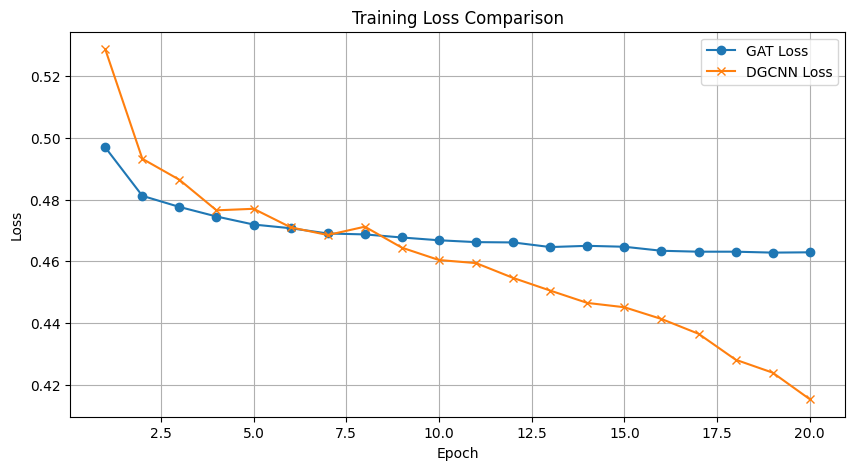

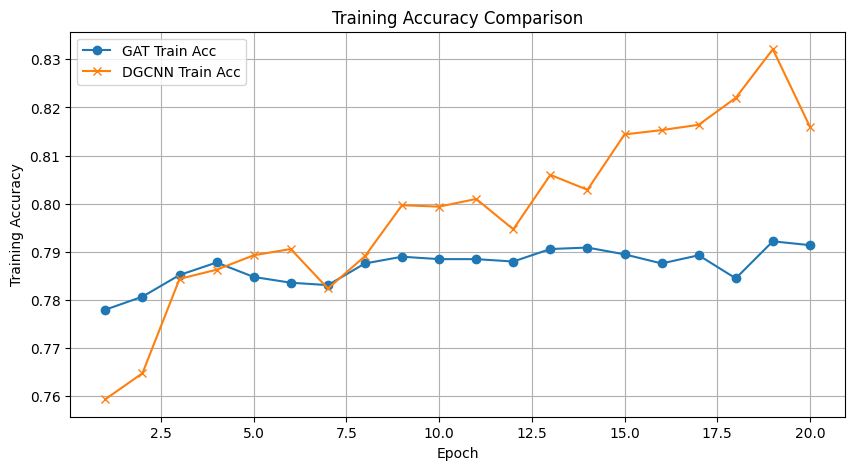

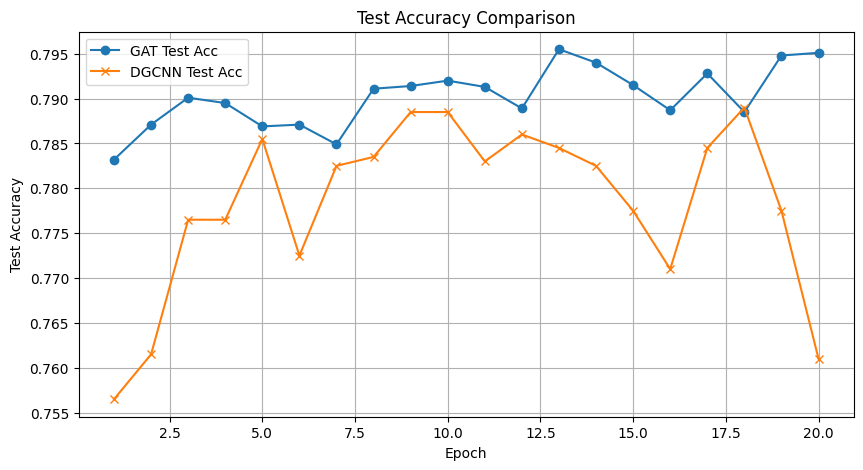

In [6]:
# Comparative Performance of GAT vs. DGCNN

# Epoch indices (1 to 20)
epochs = list(range(1, 21))

# GAT logs (from your output)
gat_loss = [0.4969, 0.4812, 0.4776, 0.4745, 0.4719, 0.4707, 0.4690, 0.4687, 0.4677, 0.4668, 0.4662, 0.4661, 0.4646, 0.4650, 0.4647, 0.4634, 0.4631, 0.4631, 0.4628, 0.4629]
gat_train_acc = [0.7780, 0.7807, 0.7852, 0.7878, 0.7848, 0.7836, 0.7831, 0.7876, 0.7890, 0.7885, 0.7885, 0.7880, 0.7906, 0.7909, 0.7895, 0.7876, 0.7893, 0.7845, 0.7922, 0.7914]
gat_test_acc  = [0.7832, 0.7871, 0.7901, 0.7895, 0.7869, 0.7871, 0.7849, 0.7911, 0.7914, 0.7920, 0.7913, 0.7889, 0.7955, 0.7940, 0.7915, 0.7887, 0.7928, 0.7885, 0.7948, 0.7951]

# DGCNN logs (from your output)
dgcnn_loss = [0.5287, 0.4932, 0.4864, 0.4765, 0.4770, 0.4710, 0.4685, 0.4712, 0.4644, 0.4604, 0.4594, 0.4546, 0.4505, 0.4465, 0.4451, 0.4413, 0.4365, 0.4281, 0.4239, 0.4153]
dgcnn_train_acc = [0.7594, 0.7648, 0.7844, 0.7863, 0.7893, 0.7906, 0.7824, 0.7891, 0.7997, 0.7994, 0.8010, 0.7947, 0.8060, 0.8029, 0.8144, 0.8153, 0.8164, 0.8220, 0.8321, 0.8160]
dgcnn_test_acc  = [0.7565, 0.7615, 0.7765, 0.7765, 0.7855, 0.7725, 0.7825, 0.7835, 0.7885, 0.7885, 0.7830, 0.7860, 0.7845, 0.7825, 0.7775, 0.7710, 0.7845, 0.7890, 0.7775, 0.7610]

# Plot Training Loss Comparison
plt.figure(figsize=(10, 5))
plt.plot(epochs, gat_loss, label="GAT Loss", marker='o')
plt.plot(epochs, dgcnn_loss, label="DGCNN Loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()

# Plot Training Accuracy Comparison
plt.figure(figsize=(10, 5))
plt.plot(epochs, gat_train_acc, label="GAT Train Acc", marker='o')
plt.plot(epochs, dgcnn_train_acc, label="DGCNN Train Acc", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.show()

# Plot Test Accuracy Comparison
plt.figure(figsize=(10, 5))
plt.plot(epochs, gat_test_acc, label="GAT Test Acc", marker='o')
plt.plot(epochs, dgcnn_test_acc, label="DGCNN Test Acc", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.show()


## GAT Model
*   Training: Loss ~0.463, Train Acc ~79.1%, Train AUC ~86.6%
*   Testing: Test Acc ~79.5%, Test AUC ~86.7%

Observations: The performance is stable across training and test sets, indicating good generalization. The attention mechanism dynamically weighs particle contributions, likely making the model robust to noise and variability in jet substructure.



# DGCNN Model


*  Training: Loss ~0.415, Train Acc ~81.6%, Train AUC ~90.5%

*  Testing: Test Acc ~76.1%, Test AUC ~85.0%

Observations: Although DGCNN achieves higher training accuracy and AUC, its test performance drops, suggesting potential overfitting. The dynamic edge computations capture detailed local interactions but might overfit on the training data without sufficient regularization.









---



---

For quark/gluon jet classification, where generalization to unseen jets is critical, the GAT model’s stable and robust test performance makes it more favorable. Its adaptive attention mechanism allows it to focus on the most relevant particle interactions, leading to better generalization despite slightly lower training metrics. In contrast, while DGCNN learns richer representations, its tendency to overfit makes it less reliable in this specific context.


---


---


